Training DCGAN on the Celeb Dataset
=====



[https://keras.io/examples/generative/dcgan_overriding_train_step/](https://keras.io/examples/generative/dcgan_overriding_train_step/)

To run notebook you will need to install [gdown](https://pypi.org/project/gdown/), a library to download large files from Google Drive.

In [56]:
!pip install gdown

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


Now let's import the necessary modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import gdown
from zipfile import ZipFile

## Prepare Celeb data



In this example we will use the Celeb dataset. We will resize images to a size of `64x64`.
First download the dataset (only need to do this once, then it will throw an error but don&rsquo;t worry):



In [ ]:
if not os.path.isdir("datasets/celeba_gan"):
    os.makedirs("datasets/celeba_gan", exist_ok=False)

    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "datasets/celeba_gan/data.zip"
    gdown.download(url, output, quiet=False)

    with ZipFile("celeba_gan/data.zip", "r") as zipobj:
        zipobj.extractall("datasets/celeba_gan")
else:
    print("Celeb directory exists")

Celeb directory exists


Check if the unzipping worked. 
And then convert this to a Tensorflow dataset. Because we expect to be training on our laptops, we will reduce the size of the training set. This is not ideal for GANs, but it will still produce reasonable results. Here we also scale the inputs to the `[-1, 1]` range and make sure the dataset is subdivided into batches of the desired size



In [ ]:
dataset_path = "datasets/celeba_gan" # Change this for your custom dataset
image_size = 64 # images are square
image_channels = 3 # 3 RGB 1 Grayscale
image_shape = (image_size, image_size, image_channels)
dataset_size = 200
batch_size = 32

dataset = keras.utils.image_dataset_from_directory(
    dataset_path, label_mode=None, image_size=(image_size, image_size), batch_size=None)

# Note. comment the following line if you will use your own dataset
dataset = dataset.take(dataset_size) 
dataset = dataset.map(lambda x: x / 127.5 - 1.0)
dataset = dataset.batch(batch_size) # We create batch here since "take" would unbatch it..

Found 202599 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Now let&rsquo;s see one random instance from the dataset:

2023-02-26 23:30:43.692084: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


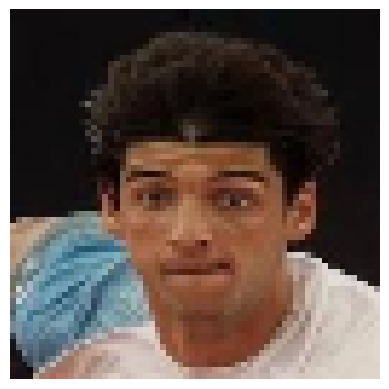

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 127.5 + 127.5).astype("int32")[0])
    break

## Create generator



At this staget we need to construct our generator. There are many implementations out there, this is one that works reasonably well for our use case and it is adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).
For GAN models it is [recommended](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/) to initialize the layers with normally distributed (Gaussian) values and standard deviation of 0.02. The following function is built to enable training on different image sizes, but we recommend sticking with the `64x64` image size:



In [112]:
latent_dim = 100 # The size of the latent space
kernel_size = 4 

# This will initialize our layers randomly
init = lambda: tf.keras.initializers.RandomNormal(stddev=0.02)

def gen_block(size):
    return keras.Sequential(
        [
            layers.UpSampling2D(),
            layers.Conv2D(size, kernel_size, padding='same', kernel_initializer=init()),
            layers.Activation("relu"),
            layers.BatchNormalization(momentum=0.8),
        ]
    )

# From https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py
# This will enable working with image sizes other than 64x64 (untested)
upsample_layers = 5
start_size =  image_size // (2 ** upsample_layers)
starting_filters = 128

generator = keras.Sequential(
    [
        layers.Input(shape=(latent_dim,)),
        layers.Dense(starting_filters * start_size * start_size, activation="relu"),
        layers.Reshape((start_size, start_size, starting_filters)),
        layers.BatchNormalization(momentum=0.8),
        gen_block(1024),
        gen_block(512),
        gen_block(128),
        gen_block(64),
        gen_block(32),
        layers.Conv2D(3, kernel_size=kernel_size, padding="same", activation="tanh", kernel_initializer=init()),
    ]
)

generator.summary(expand_nested=True, line_length=100)

Model: "sequential_193"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 dense_40 (Dense)                            (None, 512)                             51712          
                                                                                                    
 reshape_24 (Reshape)                        (None, 2, 2, 128)                       0              
                                                                                                    
 batch_normalization_147 (BatchNormalization  (None, 2, 2, 128)                      512            
 )                                                                                                  
                                                                                                    
 sequential_188 (Sequential)                 (None, 4, 4, 1024)    

Let&rsquo;s see it&rsquo;s output before training



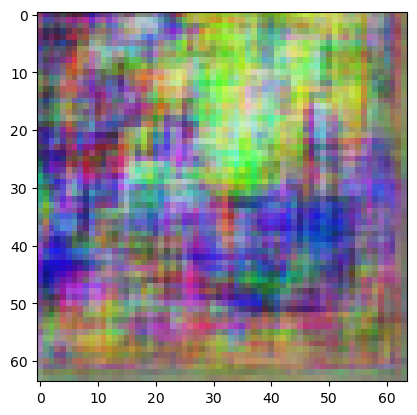

In [113]:
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=True)
plt.imshow(generated_image[0, :, :]*0.5+0.5)
plt.show()

## Create discriminator



We then define the discriminator model, again adapted adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).



In [114]:
kernel_size = 3
def disc_block(size, strides, batch_norm=True, padding=False):
    layer_list = [
                  layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=init()), # Always keep
                  layers.LeakyReLU(alpha=0.2), # Always keep
                  layers.Dropout(0.1) # Try to comment
                  ]
    if padding:
        layer_list += [layers.ZeroPadding2D(padding=((0,1),(0,1)))] # Always keep
    if batch_norm:
        layer_list += [layers.BatchNormalization(momentum=0.8)] 
    return keras.Sequential(layer_list)

discriminator = keras.Sequential(
    [
        keras.Input(shape=image_shape),
        disc_block(32, 2, batch_norm=False),
        disc_block(64, 2, batch_norm=True, padding=True),
        disc_block(128, 2, batch_norm=True),
        disc_block(256, 1, batch_norm=False),
        disc_block(512, 1, batch_norm=False),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ]
)   
        
        
discriminator.summary(expand_nested=True)

Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_194 (Sequential)  (None, 32, 32, 64)       1792      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_187 (Conv2D)       (None, 32, 32, 64)        1792      |
|                                                               |
| leaky_re_lu_69 (LeakyReLU)  (None, 32, 32, 64)      0         |
|                                                               |
| dropout_30 (Dropout)      (None, 32, 32, 64)        0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_195 (Sequential)  (None, 17, 17, 64)       37184     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_188 (Conv2D)       (None, 16, 16, 64)        36928     |
|                                                               |
| leaky_re_lu_70 (LeakyReLU)  (None, 16, 16, 64)    

Let&rsquo;s see what the discriminator thinks of our generated image:



In [115]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4999366]], shape=(1, 1), dtype=float32)


# Train the network
Tensorflow and Keras offer many ways to combine the generator and discriminator into a GAN model and train it. Here we follow one approach that appears to work relatively well for a small number of images, in which we manually define the training loop. 

In [111]:
optimizer = tf.keras.optimizers.legacy.Adam(0.0001, 0.5, decay=0.00005)

discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,

                      metrics=['accuracy'])


# The generator takes noise as input and generates imgs
z = keras.Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
#%%

epochs = 60 #50
save_interval = 1

model_path = "./models/dcgan_dmlap"
os.makedirs(model_path, exist_ok=True)
import sys

for epoch in range(epochs):
    n = dataset.cardinality() # The number of batches per epoch
    # Iterate over all batches
    for i, batch in enumerate(dataset.as_numpy_iterator()):
        # Convert batch to numpy for convenience
        half_batch_size = len(batch)//2

        # Train generator
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
        discriminator.trainable = True

        # Get random half of the batch
        idx = np.random.randint(0, batch.shape[0], half_batch_size)
        imgs = batch[idx]
        # For the remaining half batch, sample noise and generate new images
        noise = np.random.normal(0, 1, (half_batch_size, 100))
        gen_imgs = generator.predict(noise, verbose=0)

        # Train the discriminator (real classified as ones and generated as zeros)
        real_labels = np.ones((half_batch_size, 1))
        fake_labels = np.zeros((half_batch_size, 1))
        noise_amt = 0.01
        real_labels += tf.random.uniform(tf.shape(real_labels))*noise_amt
        fake_labels += tf.random.uniform(tf.shape(fake_labels))*noise_amt
        d_loss_real = discriminator.train_on_batch(imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Print progress on same line
        sys.stdout.write("\r" + "Epoch %d - %d of %d "%(epoch+1, i+1, n) + "[D loss: "+str(d_loss[0])+" | D Accuracy: "+str(100 * d_loss[1])+"] [G loss: "+str(g_loss)+"]")

    if epoch % save_interval == 0:
        print('Saving epoch %d to %s'%(epoch+1, model_path))
        num_examples = 5
        random_latent_vectors = tf.random.normal(shape=(num_examples, latent_dim))
        generated_images = generator(random_latent_vectors, training=False)
        #generated_images *= 255
        generated_images = generated_images * 127.5 + 127.5 #255
        generated_images.numpy()
        for i in range(num_examples):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(model_path, "e%03d_generated_img_%d.png" % (epoch+1, i)))

        generator.save(os.path.join(model_path, "e%0d_generator.hd5"%(epoch+1)), save_format='h5')


Epoch 1
Epoch 1 - 7 of 7 [D loss: 0.5239430963993073 | D Accuracy: 0.0] [G loss: 0.6915512084960938]Saving epoch 1 to ./models/dcgan_dmlap
Epoch 2
Epoch 2 - 7 of 7 [D loss: 0.7327122241258621 | D Accuracy: 0.0] [G loss: 0.7353137731552124]Saving epoch 2 to ./models/dcgan_dmlap
Epoch 3
Epoch 3 - 7 of 7 [D loss: 0.5370155274868011 | D Accuracy: 0.0] [G loss: 0.9488980174064636]Saving epoch 3 to ./models/dcgan_dmlap
Epoch 4
Epoch 4 - 7 of 7 [D loss: 0.41593898832798004 | D Accuracy: 0.0] [G loss: 0.9730563163757324]Saving epoch 4 to ./models/dcgan_dmlap
Epoch 5
Epoch 5 - 7 of 7 [D loss: 0.38536907732486725 | D Accuracy: 0.0] [G loss: 0.938506007194519]Saving epoch 5 to ./models/dcgan_dmlap
Epoch 6
Epoch 6 - 7 of 7 [D loss: 0.5312990546226501 | D Accuracy: 0.0] [G loss: 0.9248051643371582]Saving epoch 6 to ./models/dcgan_dmlap
Epoch 7
Epoch 7 - 7 of 7 [D loss: 0.46160727739334106 | D Accuracy: 0.0] [G loss: 1.0843892097473145]Saving epoch 7 to ./models/dcgan_dmlap
Epoch 8
Epoch 8 - 7 of 7 

KeyboardInterrupt: 